In [96]:
# install.packages("partykit")
# install.packages("pre")
library("partykit")
source("SimData.r")
library("party")
library(MASS)
library("glmertree")
library("caret") # importance and rfe
source("SimData.r")
library("randomForest")
library("rpart")
library("fuzzyforest")
library("WGCNA")
library("pre")

# data

In [175]:
# training data
n <- 300 # number of patients
T <-  5 # number of observations per patients

set.seed(100)

data <- sim_quad(n,T)


#add PC
data$PC1 = (prcomp(data[,1:100], scale = TRUE)$x)[,1]
# data$PC1 = scale(data$PC1)/norm(scale(data$PC1),type="2")
data$PC2 = (prcomp(data[,101:200], scale = TRUE)$x)[,1]
data$PC3 = (prcomp(data[,201:300], scale = TRUE)$x)[,1]

# add time_squared
data$time2 = (data$time)^2

# # add group*time interaction
# data$time_G1 = data$time * data$group1 # b1, time*group1
# data$time_G2 = data$time * data$group2 # b2
# data$time2_G1 = (data$time)^2 * data$group1 # b1 time^2 * group1
# data$time2_G2 = (data$time)^2 * data$group2 # b2


head(data)

V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V400,rand_int,time,treatment,patient,y,PC1,PC2,PC3,time2
-0.22639210,0.81443928,-0.18860973,0.04338155,0.37014582,0.6551589,-0.17059459,0.24426073,-0.20974352,0.1123240,...,1.2914083,-1.1292200,1,1,1,9.524252,0.62389770,-10.1083062,-4.4945580,1
0.68677964,0.57248556,1.24667973,1.23135441,1.49959068,0.5091811,0.78242384,0.97656076,1.28591876,0.4078879,...,0.6706417,-1.1292200,2,1,1,18.428301,8.65590878,4.1090531,1.1019176,4
0.13318218,-0.31200261,-0.03291953,-0.30982433,-1.19590729,0.2999424,-0.08408689,0.02549711,-0.25523483,-0.4869125,...,-0.3064880,-1.1292200,3,1,1,0.212801,-0.07441721,6.4346365,-0.7594888,9
1.12524619,0.98390428,0.40812092,1.82101104,1.73652356,0.8785987,0.64457809,1.26073687,1.23596118,1.0116215,...,-2.1996032,-1.1292200,4,1,1,5.338540,13.97829585,3.6413830,7.7590574,16
0.08731483,0.06145538,0.95790617,-0.58046754,0.01387623,0.2118406,0.14765551,-0.21176913,-0.08791745,0.0147104,...,-0.3475930,-1.1292200,5,1,1,30.596277,-0.96755639,-12.8179006,0.9656345,25
0.95526683,1.14314341,1.55470983,0.78913108,1.00692117,0.6834258,1.32285818,1.06078330,1.44416315,2.4706603,...,0.7219095,-0.1064768,1,1,2,45.359753,13.99136538,-0.1321276,2.7455526,1


In [176]:
# testing data
n_test <- 100 # number of patients
T <-  5 # number of observations per patients

set.seed(101)

data_test <- sim_quad(n_test, T)


#add PC: only for testing; In our final algorithm we don't need PC of test data
data_test$PC1 = (prcomp(data_test[,1:100], scale = TRUE)$x)[,1]
# data$PC1 = scale(data$PC1)/norm(scale(data$PC1),type="2")
data_test$PC2 = (prcomp(data_test[,101:200], scale = TRUE)$x)[,1]
data_test$PC3 = (prcomp(data_test[,201:300], scale = TRUE)$x)[,1]

# add time_squared
data_test$time2 = (data_test$time)^2

# add group*time interaction
# data_test$time_G1 = data_test$time * data_test$group1 # b1, time*group1
# data_test$time_G2 = data_test$time * data_test$group2 # b2
# data_test$time2_G1 = (data_test$time)^2 * data_test$group1 # b1 time^2 * group1
# data_test$time2_G2 = (data_test$time)^2 * data_test$group2 # b2

head(data_test)

V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V400,rand_int,time,treatment,patient,y,PC1,PC2,PC3,time2
-0.1794102,-0.7293793,-0.5451425,-0.6759157,-0.69938339,-0.7425785,-0.36740919,-0.05614226,-0.4689813,-0.9957741,...,0.04467189,0.9913158,1,1,1,17.982681,-4.052595,-11.7896739,-2.429686,1
0.8907442,2.0446333,2.2867130,1.9176666,1.18491329,1.4608648,1.57879314,1.51672880,1.4702505,1.8208692,...,0.56829129,0.9913158,2,1,1,39.950832,18.372992,-6.1072477,5.657972,4
0.2463468,-0.3266239,-0.1396596,-0.1119510,0.39615391,0.7130694,-0.56640362,0.43538748,0.3228802,0.1798426,...,-0.61422493,0.9913158,3,1,1,-2.840054,1.099723,-2.7001757,-5.626646,9
-0.6415846,-0.1170245,-1.2137791,-1.4818147,-1.02402806,-0.8341220,-0.92867891,-0.63758937,-1.6522012,-1.5747861,...,0.56752086,0.9913158,4,1,1,-5.957963,-8.471346,-5.2856326,2.560440,16
-1.2865155,0.1642321,0.6040035,-0.2489238,-0.39677846,0.3232312,0.02991788,-0.93041047,-0.5375453,0.2817597,...,0.18072176,0.9913158,5,1,1,11.513002,0.974368,-0.1528867,3.451664,25
0.6467019,-0.6255761,0.4649954,0.4595883,0.08918262,-0.4334162,0.08811692,0.20140550,0.1705507,-0.2342035,...,-3.27472578,0.6967010,1,1,2,19.294548,2.479159,2.4828303,11.382378,1


In [177]:
# Methods for extracting names of splitting features used in a tree
# tree: a tree object; data: the train or test set
get_split_names = function(tree,data){
    # path: the string that contains all the node information
    paths <- pre:::list.rules(tree, removecomplements = FALSE)
    vnames = names(data)
    # the regex for a variable
    # tomatch = paste(paste(var,"<="),"|",paste(var,">"),sep="")
    # match to tomatch in path
    tmp = vnames[sapply(sapply(vnames, FUN = function(var) grep(paste(paste(var,"<="),"|",paste(var,">"),sep=""), paths)), length) > 0]
    return (tmp)
}

# Automatic version

In [190]:
start_time <- Sys.time()

data_WGCNA = data[,1:400] # only the covariates
# choose power = 6, which is not quite correct
# Please set numericLabels = FALSE so that the label is one color (string)
# if verbose = 3, show some details
net = blockwiseModules(data_WGCNA, power = 6,TOMType = "unsigned", 
                       minModuleSize = 30,reassignThreshold = 0, 
                       mergeCutHeight = 0.25,numericLabels = FALSE, 
                       pamRespectsDendro = FALSE,verbose = 0)

# the correspondance betweeen feature names and colors
colors = net$colors # it is a string vector with names (that is the name is V1)
# Get a list with the first element being all the names of first groups and so on
# all the names of modules
module_names = unique(colors) # all colors name

# a vector with name(index) = names of modules and value = the corresponding names
# of features (like a dictionary)
module_dic = list()
for (i in 1:length(module_names)){
    module_dic[[module_names[i]]] = names(colors[colors==module_names[i]])
}
# module_dic

In [191]:
##### eigengene: here we may not need this since we have time as regressor ####
# # extract eigengenes and rename the column.
# # The eigengene(1st pricinpal component) is L2 normalized
# eigengene = net$MEs
# # eigengene
# # add eigengen to training data
# for (name in module_names){
#     if (name == "grey"){
#         next
#     }
#     eigen_name = paste("ME",name,sep="")
#     data[[eigen_name]] = eigengene[[eigen_name]]
# }
# # head(data)
##### end eigengene ####

In [192]:
imp_var = list() # used to store the names of important features
cluster_var = "patient" # the name should be specified by the users

# For each module including grey, use model tree as following:
# use its time and time2 as regression variables
# use all features in the module + treatment as splitting variables
# Finally, use all the chosen features for splitting and regression variables

# for non-grey groups
for (name in module_names){
    
    # in the formula, add treatment as split_var, also include the module features
    split_var = c(module_dic[[name]],"treatment")
    
    # use time and time2 as regressor
    regress_var = c("time2","time")
    
    # Formula for lmtree: use PC as regressors
    Formula = as.formula(paste("y~",paste(regress_var,collapse = "+"),
                           "|",cluster_var,"|",
                paste(split_var,collapse = "+")))
    
    # fit the tree
    mytree = lmertree(Formula, data = data,alpha = 0.2,maxdepth=5) 
    
    #extract important features
    imp_var[[length(imp_var)+1]] = get_split_names(mytree$tree,data)
    
#     plot(mytree)
#     flush.console()
#     cat("\n",get_split_names(mytree$tree,data),"\n")
    # to print the error, we have to add PC to test data
#     print(mean((predict(mytree,newdata=data_test)-data_test$y)**2))
}


imp_var 

boundary (singular) fit: see ?isSingular
boundary (singular) fit: see ?isSingular
boundary (singular) fit: see ?isSingular
boundary (singular) fit: see ?isSingular


[[1]]
[1] "V1"  "V2"  "V3"  "V14" "V26" "V68"

[[2]]
[1] "V106" "V154" "V172"

[[3]]
character(0)

[[4]]
[1] "V301" "V302" "V303" "V319" "V348"

In [193]:
# the variables selected from all the modules
final_var = imp_var[[1]]
if (length(imp_var)>1){
    for (i in 2:length(imp_var)){
    final_var = c(final_var,imp_var[[i]])
 }
}
final_var

[1] "V1"   "V2"   "V3"   "V14"  "V26"  "V68"  "V106" "V154" "V172" "V301"
[11] "V302" "V303" "V319" "V348"

In [194]:
# the final selection among all the chosen features 
regress_var = c("time2","time")
split_var = c(final_var,"treatment")
Formula = as.formula(paste("y~",paste(regress_var,collapse = "+"),
                           "|",cluster_var,"|",
                         paste(split_var,collapse = "+")))
mytree = lmertree(Formula, data = data,alpha = 0.2,maxdepth=8) 
final_var = get_split_names(mytree$tree,data)
final_var

boundary (singular) fit: see ?isSingular
boundary (singular) fit: see ?isSingular


[1] "V1"   "V2"   "V3"   "V14"  "V26"  "V301" "V302" "V303"

In [195]:
# final_var = paste("V",c(1,2,3,301,302,303),sep="") # if cheating

In [196]:
# use the final features as split&regression variables
split_var = c(final_var,"treatment")
regress_var = c("time2","time",final_var)
Formula = as.formula(paste("y~",paste(regress_var,collapse = "+"),
                           "|",cluster_var,"|",
                         paste(split_var,collapse = "+")))
mytree = lmertree(Formula, data = data,alpha = 0.2,maxdepth=5) 

Time difference of 33.71858 secs

[1] 19.75224

$patient


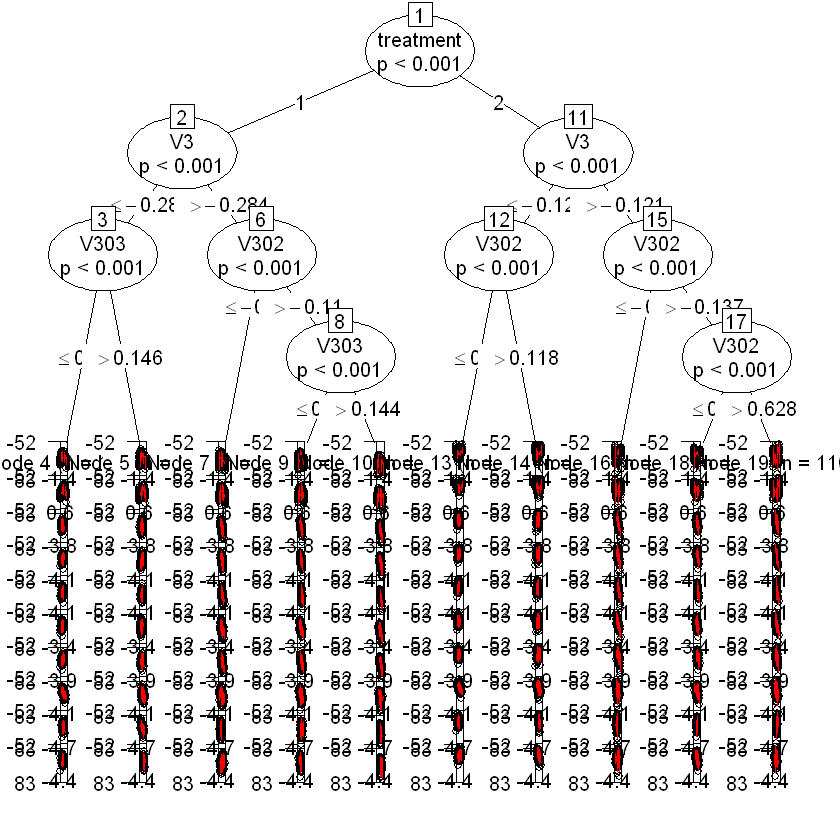

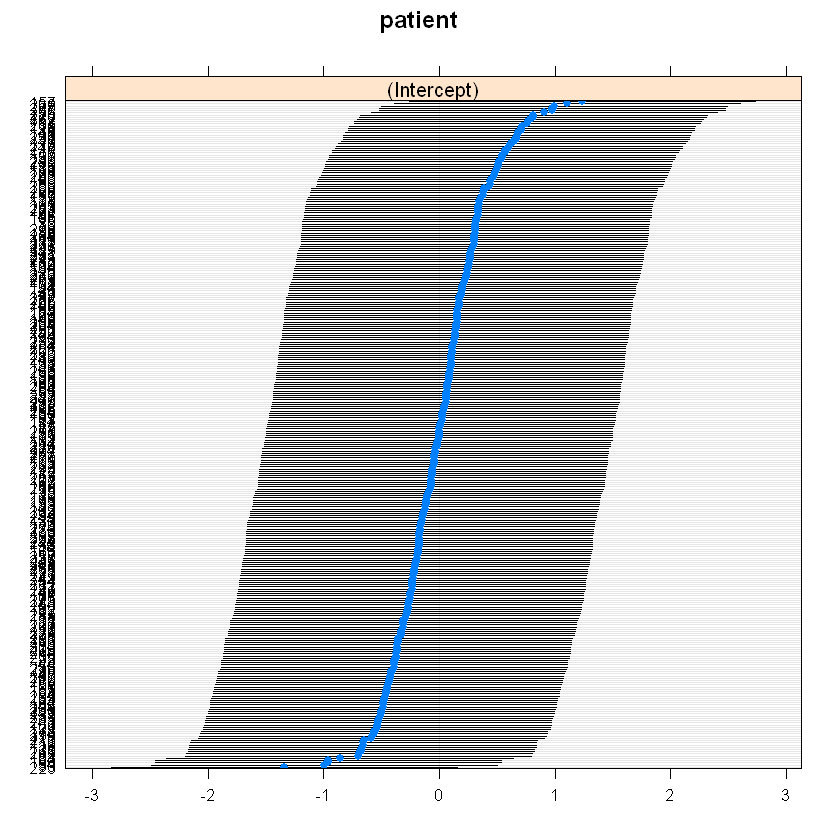

In [197]:
end_time <- Sys.time()
end_time - start_time # running time

mean((predict(mytree,newdata=data_test)-data_test$y)**2)
plot(mytree)

In [198]:
coef(mytree)

,(Intercept),time2,time,V1,V2,V3,V14,V26,V301,V302,V303
4,42.51777,5.227858,-31.70071,6.470637,-3.026975,-4.409084,-0.18271481,-0.75421112,5.111861,-0.7073013,1.197642
5,39.62772,4.851176,-29.21145,4.430918,-3.451379,-4.448791,0.66413727,0.51004262,4.937008,7.4404257,1.890546
7,42.42252,4.868481,-28.71184,4.325621,5.171950,5.668891,-0.01485862,0.42967762,4.697431,2.8265760,-2.550320
9,46.65298,5.005346,-30.15649,3.905625,5.040356,6.084989,0.86593751,0.55340705,5.144736,-1.3958327,5.150272
10,38.18891,4.860115,-29.09383,4.322683,5.623170,7.305882,0.85969625,-0.06621209,4.979167,6.5475117,5.787470
13,-49.08472,-5.001739,30.15028,5.728657,-1.894553,-3.990115,-0.23986884,-0.38187145,5.181894,1.3565125,-1.093634
14,-49.39656,-5.204704,31.13339,4.901178,-3.556120,-3.741694,0.79800894,0.17373676,5.370356,1.6442882,7.046237
16,-46.14354,-4.718740,28.40805,6.349842,5.638385,7.263284,0.04858909,-0.60348496,5.406017,1.9495831,-1.925624
18,-45.30559,-4.731720,28.74874,5.060294,4.581159,6.574929,-0.53957169,0.94118924,5.167341,0.6610784,3.465979
19,-43.89882,-4.851259,29.07933,6.472495,6.751904,7.115071,-0.22916565,-1.55672259,5.229233,-0.6183824,7.243852


# Model tree: step by step version

   user  system elapsed 
   2.95    1.03    5.54 

[1] 76.97688

[1] "V1"   "V2"   "V3"   "V301"

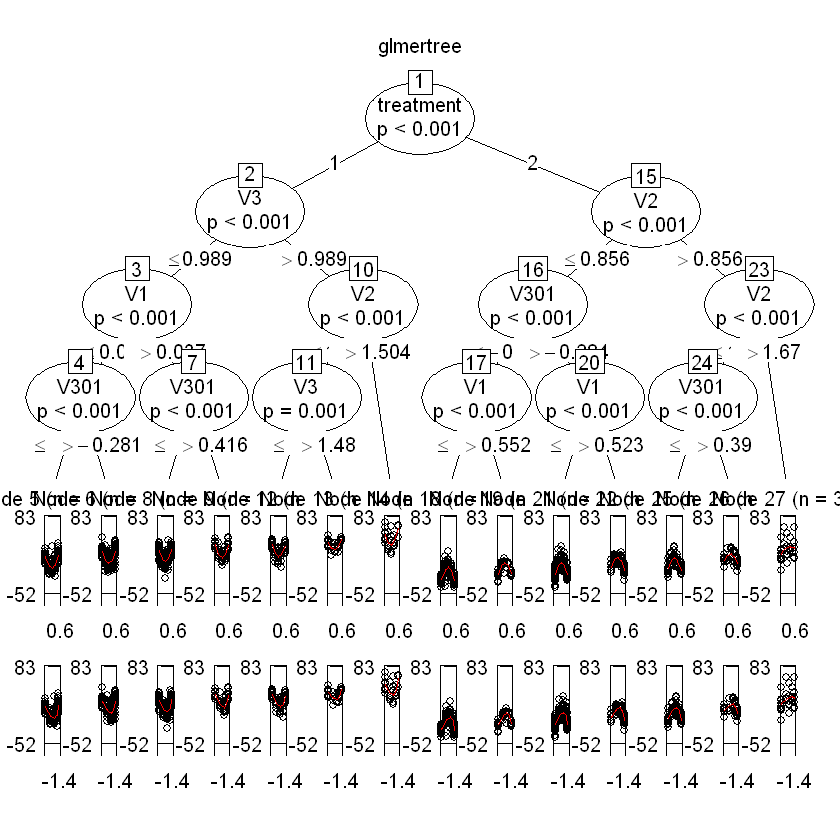

In [200]:
# split_var = c("treatment",paste("V",1:100,sep=""))
# split_var = c("treatment")
split_var = c("treatment",paste("V",c(1,2,3,301,302,303),sep=""))
# split_var = c("treatment",paste("V",c(1,2,3,301,302,303),sep="")) # correct

# regress_var = c("time2","time")
# regress_var = c("V1")
regress_var = c("time","time2")
# regress_var = c("time2","time",paste("V",c(1,2,3,301,302,303),sep=""))

cluster_var = "patient"
Formula = as.formula(paste("y~",paste(regress_var,collapse = "+"),
                           "|",cluster_var,"|",
                         paste(split_var,collapse = "+")))
# Formula

system.time({
    # you can change alpha = 0.2
    lmm_tree <- lmertree(Formula, data = data,alpha = 0.3,maxdepth=5) 
})
# mean square error on test data
mean((predict(lmm_tree,newdata=data_test,re.form=NA)-data_test$y)**2)

# the selected features
get_split_names(lmm_tree$tree,data)

# coef(lmm_tree)
plot(lmm_tree,which="tree",main = "glmertree")

In [201]:
coef(lmm_tree)

,(Intercept),time,time2
5,40.99118,-31.895063,5.182074
6,44.33446,-29.283495,4.927686
8,48.76405,-29.716642,4.888221
9,57.95539,-31.696468,5.331493
12,54.18950,-28.757700,4.930032
13,59.97979,-21.679963,3.417342
14,91.13816,-36.518382,5.665010
18,-56.45577,33.079386,-5.436157
19,-40.96788,28.767228,-4.876719
21,-44.44926,30.595360,-5.067669


In [16]:
# random effect (here is just intercept)
# ranef(lmm_tree)

# Benchmark

   user  system elapsed 
 863.49   29.11 1071.83 

[1] 50.01623

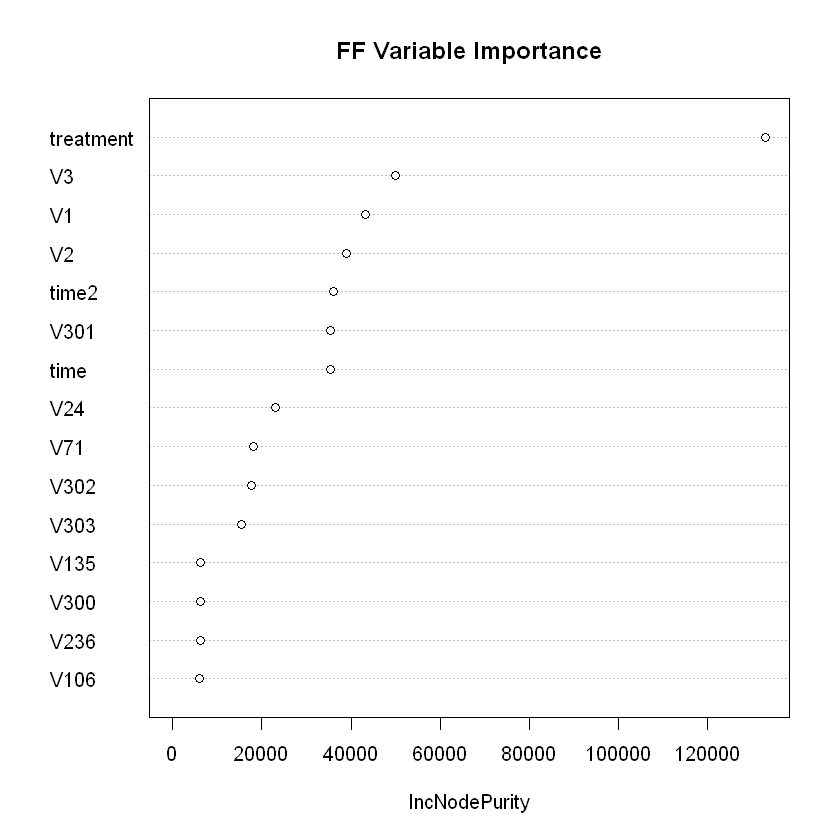

In [187]:
# since treatment is categorical, we cannot include it in WGCNA

system.time({
data_WGCNA = data[,1:400] # only the covariates
# choose power = 6, which is not quite correct
# Please set numericLabels = FALSE so that the label is one color (string)
# if verbose = 3, show some details
net = blockwiseModules(data_WGCNA, power = 6,TOMType = "unsigned", 
                       minModuleSize = 30,reassignThreshold = 0, 
                       mergeCutHeight = 0.25,numericLabels = FALSE, 
                       pamRespectsDendro = FALSE,verbose = 0)

var = c(paste("V",1:400,sep=""),"time","time2","treatment")
Formula = as.formula(paste("y~",paste(var,collapse = "+")))
    
net$colors[["time"]] = "grey"
net$colors[["time2"]] = "grey"
net$colors[["treatment"]] = "grey"
    
# var = paste("V",1:400,sep="")
# Formula = as.formula(paste("y~",paste(var,collapse = "+")))
    


ff_fit = ff(Formula,data = data,module_membership=net$colors,
        screen_params = screen_control(min_ntree = 500),
        select_params = select_control(min_ntree = 500,number_selected = 15), 
        final_ntree = 5000, num_processors = 1)        
})
mean((predict(ff_fit,new_data=data_test)-data_test$y)**2)
varImpPlot(ff_fit$final_rf,type=2,main="FF Variable Importance")

   user  system elapsed 
  80.98    0.20   82.25 

[1] 77.45231

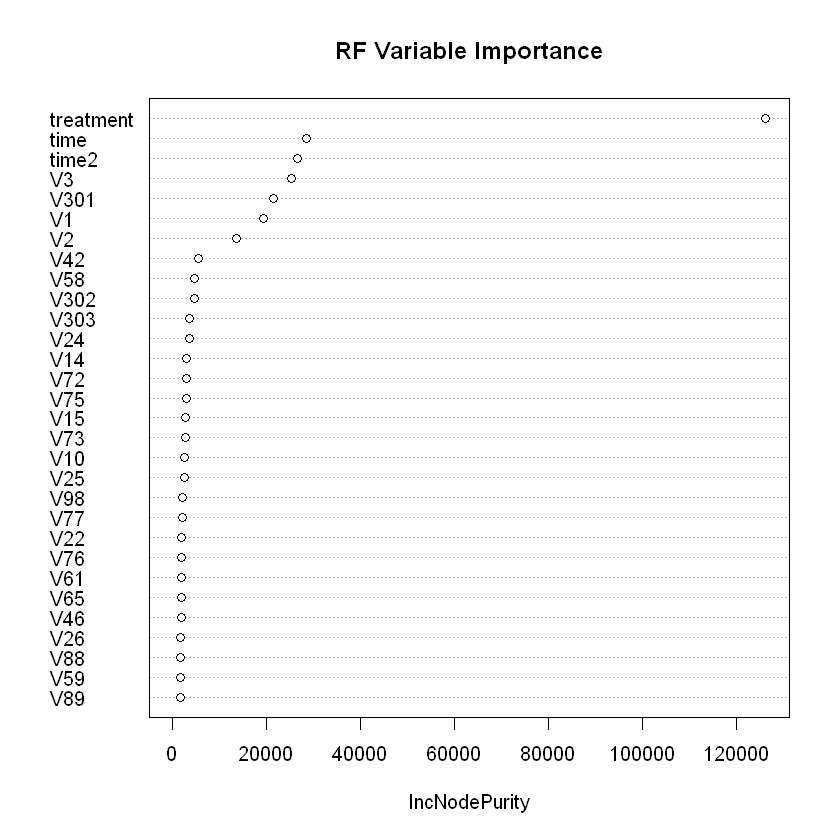

In [188]:
# Random Forest
var = c(paste("V",1:400,sep=""),"time","time2","treatment")
Formula = as.formula(paste("y~",paste(var,collapse = "+")))
system.time({
#     set.seed(20)
    rf <- randomForest(Formula,data)
})
mean((predict(rf,newdata=data_test)-data_test$y)**2)
varImpPlot(rf,type=2,main="RF Variable Importance")